# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [189]:
df_agg = pd.read_csv('./data_agg.csv', parse_dates=['Date'])
# df_agg.head()

In [190]:
columns = df_agg.columns[-7:]
columns

Index(['Age', 'Sex', 'PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO',
       'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %'],
      dtype='object')

# Geração de Amostras com VAE

In [191]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

In [192]:
# Baseado em: https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.

        loss_mse (torch.Tensor): The reconstruction loss MSE component of the VAE loss.
        loss_bin (torch.Tensor): The reconstruction loss binary CE component of the VAE loss.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor

    loss_recon_mse: torch.Tensor
    loss_recon_bin: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor


In [193]:
class SigmoidFirstValue(nn.Module):
    def __init__(self):
        super(SigmoidFirstValue, self).__init__()

    def forward(self, x):
        # Apply sigmoid to the first value
        x[:, 0] = torch.sigmoid(x[:, 0])
        return x

In [194]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
        beta (float): Weight for the KL divergence term.
        alpha (float): Weight for the MSE loss term.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0, alpha=0.9):
        super(VAE, self).__init__()

        self.beta = beta
        self.alpha = alpha

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, 2 * latent_dim), # 2 for mean and variance.
        )
        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.SiLU(),
            nn.Linear(hidden_dim // 2, input_dim),
            # nn.Sigmoid(),
        )

        self.sigmoid_first_value = SigmoidFirstValue()

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        x_recon = self.decoder(z)
        x_recon = self.sigmoid_first_value(x_recon)
        return x_recon

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon_mse=None,
                loss_recon_bin=None,
                loss_recon=None,
                loss_kl=None,
            )

        # compute loss terms
        # loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        # loss_recon = F.mse_loss(recon_x, x, reduction='none').sum(-1).mean()

        loss_recon_bin = F.binary_cross_entropy(recon_x[:, 0], x[:, 0], reduction='none').sum(-1).mean()
        loss_recon_mse = F.mse_loss(recon_x[:, 1:], x[:, 1:], reduction='none').sum(-1).mean()
        loss_recon = (1 - self.alpha) * loss_recon_bin + self.alpha * loss_recon_mse

        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon +  self.beta * loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon_mse=loss_recon_mse,
            loss_recon_bin=loss_recon_bin,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )


## Dataloader

In [195]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

In [196]:
columns = list(columns)
columns[0], columns[1] = columns[1], columns[0]

X_values = df_agg[columns].values
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_values)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

In [197]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    X_train,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    X_test,
    batch_size=batch_size,
    shuffle=False,
)

## Model Training

In [198]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [199]:
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 3
hidden_dim = 6
beta = 1.0
alpha = 0.95

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VAE(input_dim=7, hidden_dim=hidden_dim, latent_dim=latent_dim, beta=beta, alpha=alpha).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
writer = SummaryWriter(f'runs/vae01/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

In [200]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Number of parameters in the model: {count_parameters(model)}")

Number of parameters in the model: 166


In [201]:
def reconstruction_fig(model, data, scaler, scaled=True):
    model.eval()
    with torch.no_grad():
        data = data.to(device)
        output = model(data, compute_loss=False)
        recon = output.x_recon.cpu().numpy()
        data = data.cpu().numpy()

        if not scaled:
            data = scaler.inverse_transform(data)
            recon = scaler.inverse_transform(recon)

        fig, ax = plt.subplots(1, 1, figsize=(4, 2))
        ax.plot(data[0], label='Original', color='blue', marker='o')
        ax.plot(recon[0], label='Reconstructed', color='red', marker='o', linestyle='--')
        ax.legend()
        ax.set_xticks([])
        ax.set_yticks([])
        # ax.set_title('Reconstruction')
        # ax.set_xlabel('Days')
        # ax.set_ylabel('Cases')
        # plt.show()
        plt.tight_layout()
        return fig

In [202]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode

    for batch_idx, data in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon Bin: {output.loss_recon_bin.item():.4f}, Recon MSE: {output.loss_recon_mse.item():.4f}, Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE_BIN', output.loss_recon_bin.item(), global_step)
                writer.add_scalar('Loss/Train/BCE_MSE', output.loss_recon_mse.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [203]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        writer.add_figure('Reconstruction', reconstruction_fig(model, data, scaler, scaled=True), global_step=cur_step)

        # Log reconstructions
        # writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        # writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)

        # Log random samples from the latent space
        # z = torch.randn(16, latent_dim).to(device)
        # samples = model.decode(z)
        # writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)


In [204]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)
writer.flush()

Epoch 1/50


  2%|▏         | 6/365 [00:00<00:07, 50.48it/s]

Step 0 (N samples: 0), Loss: 6.0904 (Recon Bin: 88.0092, Recon MSE: 1.0649, Recon: 5.4121, KL: 0.6783) Grad: 2.1867


 38%|███▊      | 139/365 [00:01<00:01, 178.37it/s]

Step 100 (N samples: 12,800), Loss: 5.2191 (Recon Bin: 88.5873, Recon MSE: 0.5079, Recon: 4.9119, KL: 0.3072) Grad: 1.5470


 61%|██████    | 222/365 [00:01<00:00, 198.67it/s]

Step 200 (N samples: 25,600), Loss: 4.5513 (Recon Bin: 88.6601, Recon MSE: 0.1142, Recon: 4.5415, KL: 0.0098) Grad: 0.4141


 90%|████████▉ | 328/365 [00:01<00:00, 199.60it/s]

Step 300 (N samples: 38,400), Loss: 4.5347 (Recon Bin: 88.6791, Recon MSE: 0.1004, Recon: 4.5293, KL: 0.0054) Grad: 0.3979


Testing: 100%|██████████| 92/92 [00:00<00:00, 384.80it/s]


====> Test set loss: 4.4715 (BCE: 4.4677, KLD: 0.0038)
Epoch 2/50


 16%|█▌        | 59/365 [00:00<00:01, 194.04it/s]

Step 400 (N samples: 51,200), Loss: 4.5237 (Recon Bin: 88.7683, Recon MSE: 0.0866, Recon: 4.5207, KL: 0.0030) Grad: 0.3380


 45%|████▍     | 164/365 [00:00<00:00, 203.76it/s]

Step 500 (N samples: 64,000), Loss: 4.5235 (Recon Bin: 88.7822, Recon MSE: 0.0859, Recon: 4.5207, KL: 0.0028) Grad: 0.1989


 74%|███████▎  | 269/365 [00:01<00:00, 203.56it/s]

Step 600 (N samples: 76,800), Loss: 4.5235 (Recon Bin: 88.7823, Recon MSE: 0.0865, Recon: 4.5213, KL: 0.0022) Grad: 0.0706


100%|██████████| 365/365 [00:01<00:00, 199.77it/s]


Step 700 (N samples: 89,600), Loss: 4.5154 (Recon Bin: 88.7931, Recon MSE: 0.0779, Recon: 4.5137, KL: 0.0017) Grad: 0.0858


Testing: 100%|██████████| 92/92 [00:00<00:00, 411.35it/s]


====> Test set loss: 4.4652 (BCE: 4.4638, KLD: 0.0014)
Epoch 3/50


 26%|██▋       | 96/365 [00:00<00:02, 131.21it/s]

Step 800 (N samples: 102,400), Loss: 4.5075 (Recon Bin: 88.6417, Recon MSE: 0.0785, Recon: 4.5067, KL: 0.0009) Grad: 0.2159


 54%|█████▎    | 196/365 [00:01<00:01, 134.68it/s]

Step 900 (N samples: 115,200), Loss: 4.5179 (Recon Bin: 88.6640, Recon MSE: 0.0880, Recon: 4.5168, KL: 0.0011) Grad: 0.2265


 80%|████████  | 292/365 [00:02<00:00, 142.32it/s]

Step 1,000 (N samples: 128,000), Loss: 4.5079 (Recon Bin: 88.6570, Recon MSE: 0.0783, Recon: 4.5073, KL: 0.0006) Grad: 0.1495


Testing: 100%|██████████| 92/92 [00:00<00:00, 277.65it/s]


====> Test set loss: 4.4634 (BCE: 4.4629, KLD: 0.0006)
Epoch 4/50


  4%|▎         | 13/365 [00:00<00:02, 129.31it/s]

Step 1,100 (N samples: 140,800), Loss: 4.5043 (Recon Bin: 88.6881, Recon MSE: 0.0731, Recon: 4.5039, KL: 0.0004) Grad: 0.1886


 35%|███▍      | 126/365 [00:00<00:01, 130.88it/s]

Step 1,200 (N samples: 153,600), Loss: 4.5217 (Recon Bin: 88.7848, Recon MSE: 0.0861, Recon: 4.5211, KL: 0.0006) Grad: 0.1498


 64%|██████▍   | 235/365 [00:01<00:00, 148.29it/s]

Step 1,300 (N samples: 166,400), Loss: 4.5135 (Recon Bin: 88.6762, Recon MSE: 0.0836, Recon: 4.5133, KL: 0.0002) Grad: 0.3356


 91%|█████████ | 331/365 [00:02<00:00, 159.18it/s]

Step 1,400 (N samples: 179,200), Loss: 4.5215 (Recon Bin: 88.9250, Recon MSE: 0.0788, Recon: 4.5211, KL: 0.0004) Grad: 0.7930


Testing: 100%|██████████| 92/92 [00:00<00:00, 266.78it/s]


====> Test set loss: 4.4636 (BCE: 4.4633, KLD: 0.0003)
Epoch 5/50


 20%|██        | 73/365 [00:00<00:01, 183.65it/s]

Step 1,500 (N samples: 192,000), Loss: 4.5241 (Recon Bin: 88.6977, Recon MSE: 0.0936, Recon: 4.5238, KL: 0.0003) Grad: 0.1256


 46%|████▋     | 169/365 [00:00<00:01, 187.31it/s]

Step 1,600 (N samples: 204,800), Loss: 4.5201 (Recon Bin: 88.7919, Recon MSE: 0.0844, Recon: 4.5197, KL: 0.0003) Grad: 0.1318


 73%|███████▎  | 267/365 [00:01<00:00, 165.06it/s]

Step 1,700 (N samples: 217,600), Loss: 4.5105 (Recon Bin: 88.7080, Recon MSE: 0.0788, Recon: 4.5102, KL: 0.0003) Grad: 0.0801


100%|██████████| 365/365 [00:02<00:00, 169.34it/s]


Step 1,800 (N samples: 230,400), Loss: 4.5032 (Recon Bin: 88.5991, Recon MSE: 0.0765, Recon: 4.5026, KL: 0.0006) Grad: 0.6278


Testing: 100%|██████████| 92/92 [00:00<00:00, 370.93it/s]


====> Test set loss: 4.4623 (BCE: 4.4621, KLD: 0.0002)
Epoch 6/50


 26%|██▌       | 95/365 [00:00<00:01, 193.05it/s]

Step 1,900 (N samples: 243,200), Loss: 4.5135 (Recon Bin: 88.6893, Recon MSE: 0.0831, Recon: 4.5134, KL: 0.0001) Grad: 0.4261


 56%|█████▌    | 204/365 [00:01<00:01, 157.62it/s]

Step 2,000 (N samples: 256,000), Loss: 4.5122 (Recon Bin: 88.6954, Recon MSE: 0.0814, Recon: 4.5121, KL: 0.0001) Grad: 0.0946


 82%|████████▏ | 300/365 [00:01<00:00, 151.89it/s]

Step 2,100 (N samples: 268,800), Loss: 4.5085 (Recon Bin: 88.6063, Recon MSE: 0.0821, Recon: 4.5083, KL: 0.0002) Grad: 0.2583


Testing: 100%|██████████| 92/92 [00:00<00:00, 316.95it/s]


====> Test set loss: 4.4621 (BCE: 4.4619, KLD: 0.0002)
Epoch 7/50


  4%|▍         | 15/365 [00:00<00:02, 146.72it/s]

Step 2,200 (N samples: 281,600), Loss: 4.5027 (Recon Bin: 88.6273, Recon MSE: 0.0748, Recon: 4.5025, KL: 0.0002) Grad: 0.2010


 38%|███▊      | 137/365 [00:00<00:01, 196.50it/s]

Step 2,300 (N samples: 294,400), Loss: 4.5114 (Recon Bin: 88.6954, Recon MSE: 0.0806, Recon: 4.5113, KL: 0.0001) Grad: 0.2351


 65%|██████▌   | 238/365 [00:01<00:00, 196.34it/s]

Step 2,400 (N samples: 307,200), Loss: 4.5116 (Recon Bin: 88.7465, Recon MSE: 0.0780, Recon: 4.5115, KL: 0.0001) Grad: 0.0611


 93%|█████████▎| 340/365 [00:01<00:00, 196.35it/s]

Step 2,500 (N samples: 320,000), Loss: 4.5180 (Recon Bin: 88.8627, Recon MSE: 0.0787, Recon: 4.5179, KL: 0.0001) Grad: 0.3615


Testing: 100%|██████████| 92/92 [00:00<00:00, 417.10it/s]


====> Test set loss: 4.4627 (BCE: 4.4626, KLD: 0.0001)
Epoch 8/50


 16%|█▋        | 60/365 [00:00<00:02, 145.59it/s]

Step 2,600 (N samples: 332,800), Loss: 4.5216 (Recon Bin: 88.6998, Recon MSE: 0.0911, Recon: 4.5215, KL: 0.0001) Grad: 0.2013


 49%|████▉     | 180/365 [00:01<00:00, 190.08it/s]

Step 2,700 (N samples: 345,600), Loss: 4.5098 (Recon Bin: 88.7805, Recon MSE: 0.0744, Recon: 4.5097, KL: 0.0001) Grad: 0.1180


 78%|███████▊  | 283/365 [00:01<00:00, 199.32it/s]

Step 2,800 (N samples: 358,400), Loss: 4.5160 (Recon Bin: 88.6917, Recon MSE: 0.0855, Recon: 4.5158, KL: 0.0001) Grad: 0.2835


100%|██████████| 365/365 [00:01<00:00, 186.99it/s]


Step 2,900 (N samples: 371,200), Loss: 4.5002 (Recon Bin: 88.5833, Recon MSE: 0.0747, Recon: 4.5002, KL: 0.0001) Grad: 0.4930


Testing: 100%|██████████| 92/92 [00:00<00:00, 433.63it/s]


====> Test set loss: 4.4620 (BCE: 4.4619, KLD: 0.0001)
Epoch 9/50


 31%|███       | 112/365 [00:00<00:01, 188.41it/s]

Step 3,000 (N samples: 384,000), Loss: 4.5073 (Recon Bin: 88.5932, Recon MSE: 0.0815, Recon: 4.5071, KL: 0.0001) Grad: 0.4530


 59%|█████▊    | 214/365 [00:01<00:00, 198.37it/s]

Step 3,100 (N samples: 396,800), Loss: 4.5163 (Recon Bin: 88.6744, Recon MSE: 0.0868, Recon: 4.5162, KL: 0.0001) Grad: 0.1365


 86%|████████▌ | 313/365 [00:01<00:00, 185.17it/s]

Step 3,200 (N samples: 409,600), Loss: 4.5087 (Recon Bin: 88.6681, Recon MSE: 0.0792, Recon: 4.5087, KL: 0.0001) Grad: 0.2649


Testing: 100%|██████████| 92/92 [00:00<00:00, 365.84it/s]


====> Test set loss: 4.4619 (BCE: 4.4619, KLD: 0.0001)
Epoch 10/50


 11%|█         | 40/365 [00:00<00:02, 136.43it/s]

Step 3,300 (N samples: 422,400), Loss: 4.5048 (Recon Bin: 88.7124, Recon MSE: 0.0728, Recon: 4.5047, KL: 0.0000) Grad: 0.0880


 39%|███▊      | 141/365 [00:00<00:01, 190.10it/s]

Step 3,400 (N samples: 435,200), Loss: 4.5155 (Recon Bin: 88.7968, Recon MSE: 0.0796, Recon: 4.5154, KL: 0.0001) Grad: 0.7206


 68%|██████▊   | 247/365 [00:01<00:00, 204.61it/s]

Step 3,500 (N samples: 448,000), Loss: 4.5001 (Recon Bin: 88.5169, Recon MSE: 0.0781, Recon: 4.5001, KL: 0.0000) Grad: 0.6105


 97%|█████████▋| 353/365 [00:01<00:00, 202.18it/s]

Step 3,600 (N samples: 460,800), Loss: 4.5016 (Recon Bin: 88.7065, Recon MSE: 0.0698, Recon: 4.5016, KL: 0.0000) Grad: 0.4555


Testing: 100%|██████████| 92/92 [00:00<00:00, 426.67it/s]


====> Test set loss: 4.4619 (BCE: 4.4619, KLD: 0.0000)
Epoch 11/50


 21%|██        | 77/365 [00:00<00:01, 188.81it/s]

Step 3,700 (N samples: 473,600), Loss: 4.5133 (Recon Bin: 88.7264, Recon MSE: 0.0810, Recon: 4.5133, KL: 0.0001) Grad: 0.0835


 49%|████▉     | 178/365 [00:00<00:00, 197.09it/s]

Step 3,800 (N samples: 486,400), Loss: 4.5146 (Recon Bin: 88.8431, Recon MSE: 0.0762, Recon: 4.5145, KL: 0.0000) Grad: 0.7275


 76%|███████▋  | 279/365 [00:01<00:00, 194.56it/s]

Step 3,900 (N samples: 499,200), Loss: 4.4928 (Recon Bin: 88.4906, Recon MSE: 0.0718, Recon: 4.4928, KL: 0.0000) Grad: 0.3438


100%|██████████| 365/365 [00:01<00:00, 193.27it/s]


Step 4,000 (N samples: 512,000), Loss: 4.5065 (Recon Bin: 88.8326, Recon MSE: 0.0682, Recon: 4.5064, KL: 0.0000) Grad: 0.3841


Testing: 100%|██████████| 92/92 [00:00<00:00, 420.25it/s]


====> Test set loss: 4.4624 (BCE: 4.4624, KLD: 0.0000)
Epoch 12/50


 32%|███▏      | 116/365 [00:00<00:01, 171.51it/s]

Step 4,100 (N samples: 524,800), Loss: 4.5137 (Recon Bin: 88.8971, Recon MSE: 0.0724, Recon: 4.5137, KL: 0.0000) Grad: 0.3101


 61%|██████▏   | 224/365 [00:01<00:00, 206.36it/s]

Step 4,200 (N samples: 537,600), Loss: 4.5162 (Recon Bin: 88.7071, Recon MSE: 0.0851, Recon: 4.5162, KL: 0.0000) Grad: 0.0499


 84%|████████▍ | 308/365 [00:01<00:00, 205.18it/s]

Step 4,300 (N samples: 550,400), Loss: 4.5263 (Recon Bin: 88.7016, Recon MSE: 0.0960, Recon: 4.5263, KL: 0.0000) Grad: 0.3009


Testing: 100%|██████████| 92/92 [00:00<00:00, 445.03it/s]


====> Test set loss: 4.4633 (BCE: 4.4633, KLD: 0.0000)
Epoch 13/50


  5%|▌         | 19/365 [00:00<00:01, 183.73it/s]

Step 4,400 (N samples: 563,200), Loss: 4.5196 (Recon Bin: 88.8355, Recon MSE: 0.0820, Recon: 4.5196, KL: 0.0000) Grad: 0.3384


 40%|████      | 146/365 [00:00<00:01, 197.77it/s]

Step 4,500 (N samples: 576,000), Loss: 4.5163 (Recon Bin: 88.6153, Recon MSE: 0.0900, Recon: 4.5163, KL: 0.0000) Grad: 0.3821


 63%|██████▎   | 229/365 [00:01<00:00, 178.07it/s]

Step 4,600 (N samples: 588,800), Loss: 4.5129 (Recon Bin: 88.7195, Recon MSE: 0.0810, Recon: 4.5129, KL: 0.0000) Grad: 0.1764


 96%|█████████▋| 352/365 [00:01<00:00, 170.11it/s]

Step 4,700 (N samples: 601,600), Loss: 4.4936 (Recon Bin: 88.7641, Recon MSE: 0.0583, Recon: 4.4936, KL: 0.0000) Grad: 0.2041


Testing: 100%|██████████| 92/92 [00:00<00:00, 372.25it/s]


====> Test set loss: 4.4630 (BCE: 4.4629, KLD: 0.0000)
Epoch 14/50


 22%|██▏       | 82/365 [00:00<00:01, 179.42it/s]

Step 4,800 (N samples: 614,400), Loss: 4.5147 (Recon Bin: 88.8598, Recon MSE: 0.0754, Recon: 4.5147, KL: 0.0000) Grad: 0.5532


 51%|█████     | 186/365 [00:01<00:00, 200.91it/s]

Step 4,900 (N samples: 627,200), Loss: 4.5217 (Recon Bin: 88.7848, Recon MSE: 0.0867, Recon: 4.5216, KL: 0.0000) Grad: 0.1598


 80%|███████▉  | 291/365 [00:01<00:00, 201.25it/s]

Step 5,000 (N samples: 640,000), Loss: 4.5225 (Recon Bin: 88.9192, Recon MSE: 0.0806, Recon: 4.5225, KL: 0.0000) Grad: 0.4149


100%|██████████| 365/365 [00:01<00:00, 185.12it/s]


Step 5,100 (N samples: 652,800), Loss: 4.5113 (Recon Bin: 88.7083, Recon MSE: 0.0798, Recon: 4.5113, KL: 0.0000) Grad: 0.4690


Testing: 100%|██████████| 92/92 [00:00<00:00, 436.49it/s]


====> Test set loss: 4.4632 (BCE: 4.4631, KLD: 0.0000)
Epoch 15/50


 34%|███▍      | 124/365 [00:00<00:01, 206.75it/s]

Step 5,200 (N samples: 665,600), Loss: 4.5248 (Recon Bin: 88.7317, Recon MSE: 0.0929, Recon: 4.5248, KL: 0.0000) Grad: 0.4136


 63%|██████▎   | 230/365 [00:01<00:00, 206.12it/s]

Step 5,300 (N samples: 678,400), Loss: 4.5170 (Recon Bin: 88.8067, Recon MSE: 0.0806, Recon: 4.5169, KL: 0.0000) Grad: 0.4318


 87%|████████▋ | 316/365 [00:01<00:00, 209.14it/s]

Step 5,400 (N samples: 691,200), Loss: 4.5256 (Recon Bin: 88.5919, Recon MSE: 0.1011, Recon: 4.5256, KL: 0.0000) Grad: 0.3833


Testing: 100%|██████████| 92/92 [00:00<00:00, 441.36it/s]


====> Test set loss: 4.4621 (BCE: 4.4621, KLD: 0.0000)
Epoch 16/50


 16%|█▌        | 58/365 [00:00<00:01, 191.08it/s]

Step 5,500 (N samples: 704,000), Loss: 4.5226 (Recon Bin: 88.8109, Recon MSE: 0.0863, Recon: 4.5226, KL: 0.0000) Grad: 0.3247


 43%|████▎     | 157/365 [00:00<00:01, 178.07it/s]

Step 5,600 (N samples: 716,800), Loss: 4.5204 (Recon Bin: 88.6858, Recon MSE: 0.0907, Recon: 4.5204, KL: 0.0000) Grad: 0.1064


 71%|███████   | 259/365 [00:01<00:00, 195.77it/s]

Step 5,700 (N samples: 729,600), Loss: 4.4958 (Recon Bin: 88.5866, Recon MSE: 0.0699, Recon: 4.4957, KL: 0.0000) Grad: 0.6187


100%|██████████| 365/365 [00:01<00:00, 186.06it/s]


Step 5,800 (N samples: 742,400), Loss: 4.5128 (Recon Bin: 88.6388, Recon MSE: 0.0851, Recon: 4.5128, KL: 0.0000) Grad: 0.6939


Testing: 100%|██████████| 92/92 [00:00<00:00, 440.97it/s]


====> Test set loss: 4.4624 (BCE: 4.4624, KLD: 0.0000)
Epoch 17/50


 22%|██▏       | 82/365 [00:00<00:01, 199.81it/s]

Step 5,900 (N samples: 755,200), Loss: 4.5235 (Recon Bin: 88.7524, Recon MSE: 0.0904, Recon: 4.5235, KL: 0.0000) Grad: 0.2382


 51%|█████     | 187/365 [00:00<00:00, 202.75it/s]

Step 6,000 (N samples: 768,000), Loss: 4.5146 (Recon Bin: 88.7895, Recon MSE: 0.0790, Recon: 4.5146, KL: 0.0000) Grad: 0.2519


 80%|████████  | 292/365 [00:01<00:00, 201.10it/s]

Step 6,100 (N samples: 780,800), Loss: 4.4949 (Recon Bin: 88.6248, Recon MSE: 0.0670, Recon: 4.4949, KL: 0.0000) Grad: 0.1954


100%|██████████| 365/365 [00:01<00:00, 197.94it/s]


Step 6,200 (N samples: 793,600), Loss: 4.5200 (Recon Bin: 88.8041, Recon MSE: 0.0839, Recon: 4.5199, KL: 0.0000) Grad: 0.3199


Testing: 100%|██████████| 92/92 [00:00<00:00, 420.29it/s]


====> Test set loss: 4.4624 (BCE: 4.4624, KLD: 0.0000)
Epoch 18/50


 33%|███▎      | 122/365 [00:00<00:01, 198.63it/s]

Step 6,300 (N samples: 806,400), Loss: 4.5082 (Recon Bin: 88.8094, Recon MSE: 0.0712, Recon: 4.5081, KL: 0.0000) Grad: 0.3501


 62%|██████▏   | 226/365 [00:01<00:00, 200.59it/s]

Step 6,400 (N samples: 819,200), Loss: 4.5044 (Recon Bin: 88.7073, Recon MSE: 0.0726, Recon: 4.5044, KL: 0.0001) Grad: 0.2264


 90%|█████████ | 330/365 [00:01<00:00, 201.63it/s]

Step 6,500 (N samples: 832,000), Loss: 4.5083 (Recon Bin: 88.7212, Recon MSE: 0.0760, Recon: 4.5082, KL: 0.0001) Grad: 0.0310


Testing: 100%|██████████| 92/92 [00:00<00:00, 446.97it/s]


====> Test set loss: 4.4619 (BCE: 4.4618, KLD: 0.0001)
Epoch 19/50


  5%|▍         | 18/365 [00:00<00:02, 172.80it/s]

Step 6,600 (N samples: 844,800), Loss: 4.5246 (Recon Bin: 88.8456, Recon MSE: 0.0866, Recon: 4.5245, KL: 0.0001) Grad: 0.2601


 44%|████▍     | 160/365 [00:00<00:01, 198.46it/s]

Step 6,700 (N samples: 857,600), Loss: 4.5197 (Recon Bin: 88.8224, Recon MSE: 0.0826, Recon: 4.5196, KL: 0.0001) Grad: 0.3178


 71%|███████   | 258/365 [00:01<00:00, 168.75it/s]

Step 6,800 (N samples: 870,400), Loss: 4.5035 (Recon Bin: 88.5469, Recon MSE: 0.0799, Recon: 4.5033, KL: 0.0002) Grad: 0.2965


100%|██████████| 365/365 [00:01<00:00, 185.05it/s]


Step 6,900 (N samples: 883,200), Loss: 4.4950 (Recon Bin: 88.5775, Recon MSE: 0.0692, Recon: 4.4946, KL: 0.0004) Grad: 0.1249


Testing: 100%|██████████| 92/92 [00:00<00:00, 431.43it/s]


====> Test set loss: 4.4613 (BCE: 4.4608, KLD: 0.0005)
Epoch 20/50


 27%|██▋       | 97/365 [00:00<00:01, 195.23it/s]

Step 7,000 (N samples: 896,000), Loss: 4.5254 (Recon Bin: 88.8440, Recon MSE: 0.0864, Recon: 4.5242, KL: 0.0012) Grad: 0.6976


 55%|█████▌    | 202/365 [00:01<00:00, 201.65it/s]

Step 7,100 (N samples: 908,800), Loss: 4.5218 (Recon Bin: 88.5828, Recon MSE: 0.0918, Recon: 4.5163, KL: 0.0055) Grad: 0.1271


 84%|████████▍ | 307/365 [00:01<00:00, 204.94it/s]

Step 7,200 (N samples: 921,600), Loss: 4.2030 (Recon Bin: 76.2955, Recon MSE: 0.1033, Recon: 3.9129, KL: 0.2901) Grad: 1.2420


Testing: 100%|██████████| 92/92 [00:00<00:00, 441.41it/s]


====> Test set loss: 2.1475 (BCE: 1.1157, KLD: 1.0318)
Epoch 21/50


  5%|▍         | 18/365 [00:00<00:02, 173.48it/s]

Step 7,300 (N samples: 934,400), Loss: 2.2729 (Recon Bin: 23.1125, Recon MSE: 0.0923, Recon: 1.2433, KL: 1.0297) Grad: 1.7202


 33%|███▎      | 121/365 [00:00<00:01, 196.42it/s]

Step 7,400 (N samples: 947,200), Loss: 1.7821 (Recon Bin: 9.5364, Recon MSE: 0.0774, Recon: 0.5503, KL: 1.2318) Grad: 0.8067


 61%|██████▏   | 224/365 [00:01<00:00, 201.72it/s]

Step 7,500 (N samples: 960,000), Loss: 1.7496 (Recon Bin: 9.1896, Recon MSE: 0.0670, Recon: 0.5231, KL: 1.2265) Grad: 2.5225


 90%|█████████ | 330/365 [00:01<00:00, 202.30it/s]

Step 7,600 (N samples: 972,800), Loss: 1.7497 (Recon Bin: 7.3735, Recon MSE: 0.0795, Recon: 0.4442, KL: 1.3055) Grad: 1.1591


Testing: 100%|██████████| 92/92 [00:00<00:00, 450.50it/s]


====> Test set loss: 1.6944 (BCE: 0.4924, KLD: 1.2020)
Epoch 22/50


 16%|█▌        | 58/365 [00:00<00:01, 190.96it/s]

Step 7,700 (N samples: 985,600), Loss: 1.8836 (Recon Bin: 12.5445, Recon MSE: 0.0888, Recon: 0.7116, KL: 1.1720) Grad: 3.7154


 44%|████▍     | 160/365 [00:00<00:01, 199.21it/s]

Step 7,800 (N samples: 998,400), Loss: 1.6187 (Recon Bin: 6.8471, Recon MSE: 0.0915, Recon: 0.4293, KL: 1.1894) Grad: 1.4708


 73%|███████▎  | 266/365 [00:01<00:00, 204.49it/s]

Step 7,900 (N samples: 1,011,200), Loss: 1.8691 (Recon Bin: 12.8019, Recon MSE: 0.0727, Recon: 0.7091, KL: 1.1600) Grad: 3.3301


 97%|█████████▋| 354/365 [00:02<00:00, 128.40it/s]

Step 8,000 (N samples: 1,024,000), Loss: 1.4957 (Recon Bin: 5.5021, Recon MSE: 0.0793, Recon: 0.3504, KL: 1.1453) Grad: 0.8538


Testing: 100%|██████████| 92/92 [00:00<00:00, 407.76it/s]


====> Test set loss: 1.5184 (BCE: 0.3885, KLD: 1.1299)
Epoch 23/50


 26%|██▌       | 94/365 [00:00<00:01, 168.05it/s]

Step 8,100 (N samples: 1,036,800), Loss: 1.5432 (Recon Bin: 7.5398, Recon MSE: 0.0755, Recon: 0.4487, KL: 1.0945) Grad: 1.5474


 57%|█████▋    | 207/365 [00:01<00:00, 187.10it/s]

Step 8,200 (N samples: 1,049,600), Loss: 1.5961 (Recon Bin: 8.5786, Recon MSE: 0.0834, Recon: 0.5081, KL: 1.0880) Grad: 3.1176


 82%|████████▏ | 300/365 [00:01<00:00, 168.54it/s]

Step 8,300 (N samples: 1,062,400), Loss: 1.3274 (Recon Bin: 4.2352, Recon MSE: 0.0906, Recon: 0.2979, KL: 1.0296) Grad: 0.7758


Testing: 100%|██████████| 92/92 [00:00<00:00, 387.13it/s]


====> Test set loss: 1.2732 (BCE: 0.3131, KLD: 0.9601)
Epoch 24/50


  4%|▎         | 13/365 [00:00<00:02, 124.48it/s]

Step 8,400 (N samples: 1,075,200), Loss: 1.1407 (Recon Bin: 2.2539, Recon MSE: 0.0774, Recon: 0.1862, KL: 0.9545) Grad: 1.3093


 39%|███▉      | 143/365 [00:00<00:01, 169.75it/s]

Step 8,500 (N samples: 1,088,000), Loss: 1.3724 (Recon Bin: 5.7170, Recon MSE: 0.0904, Recon: 0.3717, KL: 1.0007) Grad: 0.9124


 67%|██████▋   | 243/365 [00:01<00:00, 191.70it/s]

Step 8,600 (N samples: 1,100,800), Loss: 1.2930 (Recon Bin: 5.0078, Recon MSE: 0.0870, Recon: 0.3330, KL: 0.9599) Grad: 2.7591


 94%|█████████▍| 344/365 [00:02<00:00, 196.82it/s]

Step 8,700 (N samples: 1,113,600), Loss: 1.1586 (Recon Bin: 3.3255, Recon MSE: 0.0783, Recon: 0.2406, KL: 0.9179) Grad: 1.1611


Testing: 100%|██████████| 92/92 [00:00<00:00, 403.60it/s]


====> Test set loss: 1.1818 (BCE: 0.2579, KLD: 0.9240)
Epoch 25/50


 16%|█▋        | 60/365 [00:00<00:01, 191.65it/s]

Step 8,800 (N samples: 1,126,400), Loss: 1.4911 (Recon Bin: 9.3829, Recon MSE: 0.0890, Recon: 0.5537, KL: 0.9373) Grad: 1.5295


 44%|████▍     | 161/365 [00:00<00:01, 196.62it/s]

Step 8,900 (N samples: 1,139,200), Loss: 1.3284 (Recon Bin: 5.9802, Recon MSE: 0.0867, Recon: 0.3814, KL: 0.9470) Grad: 1.1771


 72%|███████▏  | 261/365 [00:01<00:00, 191.39it/s]

Step 9,000 (N samples: 1,152,000), Loss: 1.1018 (Recon Bin: 0.9507, Recon MSE: 0.0899, Recon: 0.1329, KL: 0.9689) Grad: 0.7284


100%|██████████| 365/365 [00:01<00:00, 193.02it/s]


Step 9,100 (N samples: 1,164,800), Loss: 1.0947 (Recon Bin: 0.3612, Recon MSE: 0.0896, Recon: 0.1032, KL: 0.9915) Grad: 2.0824


Testing: 100%|██████████| 92/92 [00:00<00:00, 390.73it/s]


====> Test set loss: 1.1936 (BCE: 0.2397, KLD: 0.9539)
Epoch 26/50


 27%|██▋       | 99/365 [00:00<00:01, 197.62it/s]

Step 9,200 (N samples: 1,177,600), Loss: 1.1071 (Recon Bin: 1.9675, Recon MSE: 0.0770, Recon: 0.1715, KL: 0.9355) Grad: 1.1233


 54%|█████▍    | 198/365 [00:01<00:01, 166.90it/s]

Step 9,300 (N samples: 1,190,400), Loss: 1.1622 (Recon Bin: 2.5072, Recon MSE: 0.0775, Recon: 0.1990, KL: 0.9632) Grad: 1.8491


 82%|████████▏ | 299/365 [00:01<00:00, 188.01it/s]

Step 9,400 (N samples: 1,203,200), Loss: 1.2174 (Recon Bin: 3.4464, Recon MSE: 0.0840, Recon: 0.2521, KL: 0.9653) Grad: 1.1722


Testing: 100%|██████████| 92/92 [00:00<00:00, 432.30it/s]


====> Test set loss: 1.1723 (BCE: 0.2227, KLD: 0.9496)
Epoch 27/50


  5%|▍         | 18/365 [00:00<00:02, 173.37it/s]

Step 9,500 (N samples: 1,216,000), Loss: 1.1820 (Recon Bin: 2.4280, Recon MSE: 0.0907, Recon: 0.2076, KL: 0.9744) Grad: 1.9689


 39%|███▉      | 142/365 [00:00<00:01, 200.46it/s]

Step 9,600 (N samples: 1,228,800), Loss: 1.3674 (Recon Bin: 7.5713, Recon MSE: 0.0698, Recon: 0.4448, KL: 0.9226) Grad: 6.7597


 67%|██████▋   | 244/365 [00:01<00:00, 195.67it/s]

Step 9,700 (N samples: 1,241,600), Loss: 1.0839 (Recon Bin: 0.7852, Recon MSE: 0.0882, Recon: 0.1230, KL: 0.9609) Grad: 1.1101


 94%|█████████▍| 344/365 [00:01<00:00, 189.94it/s]

Step 9,800 (N samples: 1,254,400), Loss: 1.1112 (Recon Bin: 2.5483, Recon MSE: 0.0722, Recon: 0.1960, KL: 0.9152) Grad: 1.3222


Testing: 100%|██████████| 92/92 [00:00<00:00, 401.09it/s]


====> Test set loss: 1.1700 (BCE: 0.2331, KLD: 0.9369)
Epoch 28/50


 21%|██        | 77/365 [00:00<00:01, 190.51it/s]

Step 9,900 (N samples: 1,267,200), Loss: 1.0488 (Recon Bin: 0.5293, Recon MSE: 0.0886, Recon: 0.1107, KL: 0.9381) Grad: 1.8192


 48%|████▊     | 177/365 [00:00<00:00, 188.90it/s]

Step 10,000 (N samples: 1,280,000), Loss: 1.1814 (Recon Bin: 3.2563, Recon MSE: 0.0770, Recon: 0.2360, KL: 0.9455) Grad: 1.6121


 76%|███████▌  | 277/365 [00:01<00:00, 192.56it/s]

Step 10,100 (N samples: 1,292,800), Loss: 1.2160 (Recon Bin: 3.3068, Recon MSE: 0.0751, Recon: 0.2367, KL: 0.9793) Grad: 1.0880


100%|██████████| 365/365 [00:01<00:00, 190.25it/s]


Step 10,200 (N samples: 1,305,600), Loss: 1.1802 (Recon Bin: 2.8947, Recon MSE: 0.0903, Recon: 0.2305, KL: 0.9497) Grad: 1.0155


Testing: 100%|██████████| 92/92 [00:00<00:00, 412.02it/s]


====> Test set loss: 1.1963 (BCE: 0.2819, KLD: 0.9144)
Epoch 29/50


 29%|██▉       | 105/365 [00:00<00:01, 192.81it/s]

Step 10,300 (N samples: 1,318,400), Loss: 1.1001 (Recon Bin: 2.2581, Recon MSE: 0.0773, Recon: 0.1863, KL: 0.9138) Grad: 3.3885


 56%|█████▌    | 204/365 [00:01<00:00, 189.87it/s]

Step 10,400 (N samples: 1,331,200), Loss: 1.0635 (Recon Bin: 0.9324, Recon MSE: 0.0770, Recon: 0.1198, KL: 0.9437) Grad: 1.3931


 84%|████████▍ | 307/365 [00:01<00:00, 195.22it/s]

Step 10,500 (N samples: 1,344,000), Loss: 1.4383 (Recon Bin: 8.2736, Recon MSE: 0.0706, Recon: 0.4807, KL: 0.9576) Grad: 2.3135


Testing: 100%|██████████| 92/92 [00:00<00:00, 397.28it/s]


====> Test set loss: 1.1707 (BCE: 0.1983, KLD: 0.9725)
Epoch 30/50


  5%|▍         | 18/365 [00:00<00:02, 173.05it/s]

Step 10,600 (N samples: 1,356,800), Loss: 1.1459 (Recon Bin: 2.3430, Recon MSE: 0.0802, Recon: 0.1933, KL: 0.9526) Grad: 0.7497


 38%|███▊      | 140/365 [00:00<00:01, 198.56it/s]

Step 10,700 (N samples: 1,369,600), Loss: 1.0753 (Recon Bin: 0.9176, Recon MSE: 0.0769, Recon: 0.1190, KL: 0.9563) Grad: 0.9307


 67%|██████▋   | 245/365 [00:01<00:00, 198.34it/s]

Step 10,800 (N samples: 1,382,400), Loss: 1.1824 (Recon Bin: 3.4504, Recon MSE: 0.0693, Recon: 0.2384, KL: 0.9440) Grad: 1.7790


 95%|█████████▌| 347/365 [00:01<00:00, 200.36it/s]

Step 10,900 (N samples: 1,395,200), Loss: 1.0602 (Recon Bin: 0.5202, Recon MSE: 0.0772, Recon: 0.0993, KL: 0.9609) Grad: 1.4793


Testing: 100%|██████████| 92/92 [00:00<00:00, 395.69it/s]


====> Test set loss: 1.1913 (BCE: 0.2640, KLD: 0.9273)
Epoch 31/50


 22%|██▏       | 79/365 [00:00<00:01, 196.11it/s]

Step 11,000 (N samples: 1,408,000), Loss: 1.1840 (Recon Bin: 3.4618, Recon MSE: 0.0762, Recon: 0.2454, KL: 0.9386) Grad: 1.3961


 44%|████▍     | 160/365 [00:00<00:01, 175.88it/s]

Step 11,100 (N samples: 1,420,800), Loss: 1.1668 (Recon Bin: 3.8592, Recon MSE: 0.0790, Recon: 0.2680, KL: 0.8989) Grad: 4.7221


 77%|███████▋  | 282/365 [00:01<00:00, 190.30it/s]

Step 11,200 (N samples: 1,433,600), Loss: 1.1077 (Recon Bin: 1.3856, Recon MSE: 0.0769, Recon: 0.1423, KL: 0.9654) Grad: 1.1141


100%|██████████| 365/365 [00:01<00:00, 185.29it/s]


Step 11,300 (N samples: 1,446,400), Loss: 1.5348 (Recon Bin: 9.3055, Recon MSE: 0.0954, Recon: 0.5559, KL: 0.9789) Grad: 1.8434


Testing: 100%|██████████| 92/92 [00:00<00:00, 424.20it/s]


====> Test set loss: 1.1836 (BCE: 0.2021, KLD: 0.9815)
Epoch 32/50


 33%|███▎      | 119/365 [00:00<00:01, 201.07it/s]

Step 11,400 (N samples: 1,459,200), Loss: 1.8104 (Recon Bin: 15.5392, Recon MSE: 0.0844, Recon: 0.8571, KL: 0.9533) Grad: 2.9697


 61%|██████    | 222/365 [00:01<00:00, 199.66it/s]

Step 11,500 (N samples: 1,472,000), Loss: 1.0960 (Recon Bin: 0.8396, Recon MSE: 0.0711, Recon: 0.1095, KL: 0.9864) Grad: 1.0452


 89%|████████▉ | 325/365 [00:01<00:00, 202.84it/s]

Step 11,600 (N samples: 1,484,800), Loss: 1.0722 (Recon Bin: 1.3251, Recon MSE: 0.0766, Recon: 0.1390, KL: 0.9332) Grad: 0.7708


Testing: 100%|██████████| 92/92 [00:00<00:00, 404.24it/s]


====> Test set loss: 1.1817 (BCE: 0.2136, KLD: 0.9680)
Epoch 33/50


  5%|▍         | 17/365 [00:00<00:02, 169.09it/s]

Step 11,700 (N samples: 1,497,600), Loss: 1.0683 (Recon Bin: 0.9052, Recon MSE: 0.0939, Recon: 0.1345, KL: 0.9338) Grad: 0.7954


 44%|████▍     | 160/365 [00:00<00:01, 200.60it/s]

Step 11,800 (N samples: 1,510,400), Loss: 1.5017 (Recon Bin: 9.1650, Recon MSE: 0.0908, Recon: 0.5445, KL: 0.9572) Grad: 1.7090


 67%|██████▋   | 245/365 [00:01<00:00, 205.20it/s]

Step 11,900 (N samples: 1,523,200), Loss: 1.2937 (Recon Bin: 5.4136, Recon MSE: 0.0788, Recon: 0.3455, KL: 0.9481) Grad: 1.9159


 96%|█████████▌| 350/365 [00:01<00:00, 202.35it/s]

Step 12,000 (N samples: 1,536,000), Loss: 1.0959 (Recon Bin: 0.7494, Recon MSE: 0.0986, Recon: 0.1311, KL: 0.9648) Grad: 1.0766


Testing: 100%|██████████| 92/92 [00:00<00:00, 445.19it/s]


====> Test set loss: 1.1800 (BCE: 0.2143, KLD: 0.9657)
Epoch 34/50


 22%|██▏       | 80/365 [00:00<00:01, 200.81it/s]

Step 12,100 (N samples: 1,548,800), Loss: 1.2700 (Recon Bin: 4.1705, Recon MSE: 0.0785, Recon: 0.2831, KL: 0.9869) Grad: 4.3976


 51%|█████     | 185/365 [00:00<00:00, 202.12it/s]

Step 12,200 (N samples: 1,561,600), Loss: 1.0610 (Recon Bin: 0.6670, Recon MSE: 0.0801, Recon: 0.1095, KL: 0.9515) Grad: 1.1510


 79%|███████▉  | 288/365 [00:01<00:00, 196.00it/s]

Step 12,300 (N samples: 1,574,400), Loss: 1.3416 (Recon Bin: 5.8624, Recon MSE: 0.0907, Recon: 0.3793, KL: 0.9623) Grad: 2.8117


100%|██████████| 365/365 [00:01<00:00, 195.34it/s]


Step 12,400 (N samples: 1,587,200), Loss: 1.1323 (Recon Bin: 2.0275, Recon MSE: 0.0633, Recon: 0.1615, KL: 0.9708) Grad: 1.2135


Testing: 100%|██████████| 92/92 [00:00<00:00, 427.00it/s]


====> Test set loss: 1.1666 (BCE: 0.2101, KLD: 0.9565)
Epoch 35/50


 31%|███       | 112/365 [00:00<00:01, 181.17it/s]

Step 12,500 (N samples: 1,600,000), Loss: 1.1042 (Recon Bin: 1.3315, Recon MSE: 0.0666, Recon: 0.1298, KL: 0.9744) Grad: 0.7184


 59%|█████▉    | 217/365 [00:01<00:00, 200.01it/s]

Step 12,600 (N samples: 1,612,800), Loss: 1.2035 (Recon Bin: 3.2548, Recon MSE: 0.0936, Recon: 0.2517, KL: 0.9518) Grad: 2.1697


 88%|████████▊ | 323/365 [00:01<00:00, 204.81it/s]

Step 12,700 (N samples: 1,625,600), Loss: 1.3033 (Recon Bin: 5.5528, Recon MSE: 0.0848, Recon: 0.3582, KL: 0.9451) Grad: 4.1140


Testing: 100%|██████████| 92/92 [00:00<00:00, 406.51it/s]


====> Test set loss: 1.1645 (BCE: 0.1763, KLD: 0.9882)
Epoch 36/50


  5%|▍         | 18/365 [00:00<00:01, 175.26it/s]

Step 12,800 (N samples: 1,638,400), Loss: 1.0769 (Recon Bin: 0.8106, Recon MSE: 0.0716, Recon: 0.1085, KL: 0.9683) Grad: 1.0109


 43%|████▎     | 156/365 [00:00<00:01, 197.73it/s]

Step 12,900 (N samples: 1,651,200), Loss: 1.1905 (Recon Bin: 3.6580, Recon MSE: 0.0868, Recon: 0.2653, KL: 0.9252) Grad: 3.1884


 70%|███████   | 257/365 [00:01<00:00, 197.56it/s]

Step 13,000 (N samples: 1,664,000), Loss: 1.0938 (Recon Bin: 1.2048, Recon MSE: 0.0771, Recon: 0.1335, KL: 0.9603) Grad: 1.2781


 99%|█████████▉| 361/365 [00:01<00:00, 194.53it/s]

Step 13,100 (N samples: 1,676,800), Loss: 1.0800 (Recon Bin: 0.2558, Recon MSE: 0.0880, Recon: 0.0964, KL: 0.9836) Grad: 1.8751


Testing: 100%|██████████| 92/92 [00:00<00:00, 393.63it/s]


====> Test set loss: 1.1780 (BCE: 0.2366, KLD: 0.9414)
Epoch 37/50


 22%|██▏       | 81/365 [00:00<00:01, 192.67it/s]

Step 13,200 (N samples: 1,689,600), Loss: 1.2408 (Recon Bin: 3.7888, Recon MSE: 0.0807, Recon: 0.2661, KL: 0.9748) Grad: 1.7131


 50%|█████     | 183/365 [00:00<00:00, 198.65it/s]

Step 13,300 (N samples: 1,702,400), Loss: 1.1861 (Recon Bin: 3.2924, Recon MSE: 0.0750, Recon: 0.2359, KL: 0.9502) Grad: 1.9095


 78%|███████▊  | 286/365 [00:01<00:00, 199.73it/s]

Step 13,400 (N samples: 1,715,200), Loss: 1.2372 (Recon Bin: 4.1299, Recon MSE: 0.0814, Recon: 0.2839, KL: 0.9533) Grad: 1.3638


100%|██████████| 365/365 [00:01<00:00, 195.54it/s]


Step 13,500 (N samples: 1,728,000), Loss: 1.0382 (Recon Bin: 1.1156, Recon MSE: 0.0756, Recon: 0.1276, KL: 0.9106) Grad: 0.7227


Testing: 100%|██████████| 92/92 [00:00<00:00, 185.08it/s]


====> Test set loss: 1.2221 (BCE: 0.3215, KLD: 0.9006)
Epoch 38/50


 33%|███▎      | 120/365 [00:00<00:01, 194.67it/s]

Step 13,600 (N samples: 1,740,800), Loss: 1.1797 (Recon Bin: 3.8556, Recon MSE: 0.0721, Recon: 0.2613, KL: 0.9184) Grad: 1.8429


 61%|██████    | 221/365 [00:01<00:00, 196.13it/s]

Step 13,700 (N samples: 1,753,600), Loss: 1.1387 (Recon Bin: 2.2498, Recon MSE: 0.0737, Recon: 0.1825, KL: 0.9562) Grad: 1.9338


 89%|████████▉ | 326/365 [00:01<00:00, 199.51it/s]

Step 13,800 (N samples: 1,766,400), Loss: 1.0749 (Recon Bin: 0.7598, Recon MSE: 0.0784, Recon: 0.1125, KL: 0.9624) Grad: 1.0169


Testing: 100%|██████████| 92/92 [00:00<00:00, 429.85it/s]


====> Test set loss: 1.1923 (BCE: 0.2696, KLD: 0.9227)
Epoch 39/50


 17%|█▋        | 62/365 [00:00<00:01, 157.46it/s]

Step 13,900 (N samples: 1,779,200), Loss: 1.0422 (Recon Bin: 0.1885, Recon MSE: 0.0825, Recon: 0.0878, KL: 0.9544) Grad: 1.8621


 46%|████▌     | 167/365 [00:00<00:00, 201.54it/s]

Step 14,000 (N samples: 1,792,000), Loss: 1.1594 (Recon Bin: 2.4427, Recon MSE: 0.0898, Recon: 0.2074, KL: 0.9520) Grad: 1.2520


 74%|███████▍  | 270/365 [00:01<00:00, 196.35it/s]

Step 14,100 (N samples: 1,804,800), Loss: 1.1477 (Recon Bin: 2.1317, Recon MSE: 0.0806, Recon: 0.1832, KL: 0.9645) Grad: 1.5575


100%|██████████| 365/365 [00:01<00:00, 186.41it/s]


Step 14,200 (N samples: 1,817,600), Loss: 1.0828 (Recon Bin: 1.4670, Recon MSE: 0.0815, Recon: 0.1508, KL: 0.9320) Grad: 0.9581


Testing: 100%|██████████| 92/92 [00:00<00:00, 441.52it/s]


====> Test set loss: 1.1609 (BCE: 0.1972, KLD: 0.9637)
Epoch 40/50


 27%|██▋       | 100/365 [00:00<00:01, 199.43it/s]

Step 14,300 (N samples: 1,830,400), Loss: 1.3100 (Recon Bin: 6.2145, Recon MSE: 0.0654, Recon: 0.3729, KL: 0.9372) Grad: 6.0987


 56%|█████▌    | 204/365 [00:01<00:00, 202.21it/s]

Step 14,400 (N samples: 1,843,200), Loss: 1.1826 (Recon Bin: 3.2437, Recon MSE: 0.0685, Recon: 0.2273, KL: 0.9554) Grad: 1.8254


 79%|███████▉  | 288/365 [00:01<00:00, 200.96it/s]

Step 14,500 (N samples: 1,856,000), Loss: 1.3871 (Recon Bin: 8.3325, Recon MSE: 0.0638, Recon: 0.4772, KL: 0.9099) Grad: 8.1748


Testing: 100%|██████████| 92/92 [00:00<00:00, 382.68it/s]


====> Test set loss: 1.1759 (BCE: 0.2327, KLD: 0.9432)
Epoch 41/50


  5%|▍         | 17/365 [00:00<00:02, 166.26it/s]

Step 14,600 (N samples: 1,868,800), Loss: 1.0803 (Recon Bin: 1.1095, Recon MSE: 0.0855, Recon: 0.1367, KL: 0.9435) Grad: 0.6260


 38%|███▊      | 140/365 [00:00<00:01, 201.43it/s]

Step 14,700 (N samples: 1,881,600), Loss: 1.0620 (Recon Bin: 0.9813, Recon MSE: 0.0792, Recon: 0.1243, KL: 0.9377) Grad: 0.6612


 61%|██████▏   | 224/365 [00:01<00:00, 203.38it/s]

Step 14,800 (N samples: 1,894,400), Loss: 1.5397 (Recon Bin: 10.2105, Recon MSE: 0.0857, Recon: 0.5919, KL: 0.9478) Grad: 3.8503


 90%|█████████ | 330/365 [00:01<00:00, 202.89it/s]

Step 14,900 (N samples: 1,907,200), Loss: 1.1309 (Recon Bin: 2.5388, Recon MSE: 0.0766, Recon: 0.1997, KL: 0.9312) Grad: 1.6550


Testing: 100%|██████████| 92/92 [00:00<00:00, 456.31it/s]


====> Test set loss: 1.1741 (BCE: 0.2085, KLD: 0.9656)
Epoch 42/50


 16%|█▌        | 58/365 [00:00<00:01, 153.84it/s]

Step 15,000 (N samples: 1,920,000), Loss: 1.2071 (Recon Bin: 3.1909, Recon MSE: 0.0818, Recon: 0.2372, KL: 0.9698) Grad: 3.0897


 44%|████▍     | 161/365 [00:00<00:01, 195.99it/s]

Step 15,100 (N samples: 1,932,800), Loss: 1.2563 (Recon Bin: 4.3621, Recon MSE: 0.0693, Recon: 0.2839, KL: 0.9724) Grad: 1.8378


 72%|███████▏  | 263/365 [00:01<00:00, 197.32it/s]

Step 15,200 (N samples: 1,945,600), Loss: 1.0780 (Recon Bin: 1.4096, Recon MSE: 0.0802, Recon: 0.1467, KL: 0.9313) Grad: 1.5740


100%|██████████| 365/365 [00:01<00:00, 184.44it/s]


Step 15,300 (N samples: 1,958,400), Loss: 1.1426 (Recon Bin: 1.7839, Recon MSE: 0.0845, Recon: 0.1695, KL: 0.9731) Grad: 0.6144


Testing: 100%|██████████| 92/92 [00:00<00:00, 420.72it/s]


====> Test set loss: 1.1535 (BCE: 0.1850, KLD: 0.9685)
Epoch 43/50


 27%|██▋       | 100/365 [00:00<00:01, 191.87it/s]

Step 15,400 (N samples: 1,971,200), Loss: 1.2553 (Recon Bin: 4.7977, Recon MSE: 0.0711, Recon: 0.3074, KL: 0.9479) Grad: 1.7219


 55%|█████▌    | 201/365 [00:01<00:00, 195.65it/s]

Step 15,500 (N samples: 1,984,000), Loss: 1.2141 (Recon Bin: 3.9243, Recon MSE: 0.0761, Recon: 0.2685, KL: 0.9457) Grad: 1.4710


 82%|████████▏ | 301/365 [00:01<00:00, 192.72it/s]

Step 15,600 (N samples: 1,996,800), Loss: 1.0744 (Recon Bin: 0.6807, Recon MSE: 0.0723, Recon: 0.1027, KL: 0.9717) Grad: 1.8937


Testing: 100%|██████████| 92/92 [00:00<00:00, 427.49it/s]


====> Test set loss: 1.1861 (BCE: 0.2116, KLD: 0.9745)
Epoch 44/50


  5%|▍         | 17/365 [00:00<00:02, 164.47it/s]

Step 15,700 (N samples: 2,009,600), Loss: 1.4604 (Recon Bin: 8.0145, Recon MSE: 0.0788, Recon: 0.4756, KL: 0.9848) Grad: 2.2405


 37%|███▋      | 135/365 [00:00<00:01, 193.12it/s]

Step 15,800 (N samples: 2,022,400), Loss: 1.1648 (Recon Bin: 3.0064, Recon MSE: 0.0825, Recon: 0.2287, KL: 0.9361) Grad: 2.4242


 64%|██████▎   | 232/365 [00:01<00:00, 171.09it/s]

Step 15,900 (N samples: 2,035,200), Loss: 1.0970 (Recon Bin: 0.6736, Recon MSE: 0.0842, Recon: 0.1136, KL: 0.9833) Grad: 1.7333


 92%|█████████▏| 336/365 [00:01<00:00, 197.68it/s]

Step 16,000 (N samples: 2,048,000), Loss: 1.2898 (Recon Bin: 4.3234, Recon MSE: 0.0808, Recon: 0.2930, KL: 0.9968) Grad: 1.3303


Testing: 100%|██████████| 92/92 [00:00<00:00, 438.14it/s]


====> Test set loss: 1.1536 (BCE: 0.1641, KLD: 0.9895)
Epoch 45/50


 22%|██▏       | 79/365 [00:00<00:01, 199.43it/s]

Step 16,100 (N samples: 2,060,800), Loss: 1.2667 (Recon Bin: 4.8981, Recon MSE: 0.0741, Recon: 0.3153, KL: 0.9514) Grad: 3.0558


 45%|████▍     | 163/365 [00:00<00:00, 203.34it/s]

Step 16,200 (N samples: 2,073,600), Loss: 1.0847 (Recon Bin: 1.4645, Recon MSE: 0.0704, Recon: 0.1402, KL: 0.9446) Grad: 0.6947


 73%|███████▎  | 268/365 [00:01<00:00, 203.11it/s]

Step 16,300 (N samples: 2,086,400), Loss: 1.5749 (Recon Bin: 11.3107, Recon MSE: 0.0922, Recon: 0.6532, KL: 0.9217) Grad: 2.0417


100%|██████████| 365/365 [00:01<00:00, 199.51it/s]


Step 16,400 (N samples: 2,099,200), Loss: 1.0915 (Recon Bin: 1.3186, Recon MSE: 0.0843, Recon: 0.1460, KL: 0.9455) Grad: 1.8224


Testing: 100%|██████████| 92/92 [00:00<00:00, 428.30it/s]


====> Test set loss: 1.1527 (BCE: 0.2088, KLD: 0.9439)
Epoch 46/50


 27%|██▋       | 99/365 [00:00<00:01, 194.12it/s]

Step 16,500 (N samples: 2,112,000), Loss: 1.0757 (Recon Bin: 0.8023, Recon MSE: 0.0827, Recon: 0.1186, KL: 0.9571) Grad: 1.2482


 55%|█████▌    | 201/365 [00:01<00:00, 198.94it/s]

Step 16,600 (N samples: 2,124,800), Loss: 1.5357 (Recon Bin: 10.4240, Recon MSE: 0.0678, Recon: 0.5856, KL: 0.9501) Grad: 2.5213


 84%|████████▎ | 305/365 [00:01<00:00, 200.51it/s]

Step 16,700 (N samples: 2,137,600), Loss: 1.2815 (Recon Bin: 4.7868, Recon MSE: 0.0817, Recon: 0.3169, KL: 0.9645) Grad: 1.7885


Testing: 100%|██████████| 92/92 [00:00<00:00, 425.17it/s]


====> Test set loss: 1.1688 (BCE: 0.2290, KLD: 0.9398)
Epoch 47/50


  5%|▍         | 18/365 [00:00<00:01, 177.15it/s]

Step 16,800 (N samples: 2,150,400), Loss: 1.0143 (Recon Bin: 0.3676, Recon MSE: 0.0728, Recon: 0.0875, KL: 0.9267) Grad: 1.3121


 39%|███▉      | 142/365 [00:00<00:01, 203.68it/s]

Step 16,900 (N samples: 2,163,200), Loss: 1.2620 (Recon Bin: 5.2897, Recon MSE: 0.0770, Recon: 0.3377, KL: 0.9243) Grad: 1.8120


 68%|██████▊   | 247/365 [00:01<00:00, 203.35it/s]

Step 17,000 (N samples: 2,176,000), Loss: 1.0981 (Recon Bin: 1.1870, Recon MSE: 0.0883, Recon: 0.1433, KL: 0.9548) Grad: 2.0472


 91%|█████████ | 332/365 [00:01<00:00, 192.42it/s]

Step 17,100 (N samples: 2,188,800), Loss: 1.3861 (Recon Bin: 7.2987, Recon MSE: 0.0893, Recon: 0.4498, KL: 0.9363) Grad: 1.8129


Testing: 100%|██████████| 92/92 [00:00<00:00, 427.67it/s]


====> Test set loss: 1.1706 (BCE: 0.2108, KLD: 0.9597)
Epoch 48/50


 19%|█▊        | 68/365 [00:00<00:01, 152.45it/s]

Step 17,200 (N samples: 2,201,600), Loss: 1.0915 (Recon Bin: 1.4360, Recon MSE: 0.0752, Recon: 0.1432, KL: 0.9483) Grad: 0.4879


 47%|████▋     | 172/365 [00:00<00:00, 198.51it/s]

Step 17,300 (N samples: 2,214,400), Loss: 1.3281 (Recon Bin: 6.6231, Recon MSE: 0.0719, Recon: 0.3994, KL: 0.9286) Grad: 3.7085


 76%|███████▌  | 277/365 [00:01<00:00, 204.30it/s]

Step 17,400 (N samples: 2,227,200), Loss: 1.1770 (Recon Bin: 3.0394, Recon MSE: 0.0863, Recon: 0.2340, KL: 0.9431) Grad: 3.7630


100%|██████████| 365/365 [00:01<00:00, 188.95it/s]


Step 17,500 (N samples: 2,240,000), Loss: 1.1603 (Recon Bin: 3.3600, Recon MSE: 0.0820, Recon: 0.2459, KL: 0.9144) Grad: 0.8519


Testing: 100%|██████████| 92/92 [00:00<00:00, 435.92it/s]


====> Test set loss: 1.1901 (BCE: 0.2463, KLD: 0.9438)
Epoch 49/50


 33%|███▎      | 120/365 [00:00<00:01, 196.55it/s]

Step 17,600 (N samples: 2,252,800), Loss: 1.0837 (Recon Bin: 0.7275, Recon MSE: 0.0751, Recon: 0.1077, KL: 0.9759) Grad: 1.1396


 55%|█████▌    | 202/365 [00:01<00:00, 200.61it/s]

Step 17,700 (N samples: 2,265,600), Loss: 1.3899 (Recon Bin: 6.9683, Recon MSE: 0.0999, Recon: 0.4433, KL: 0.9466) Grad: 2.6207


 84%|████████▍ | 307/365 [00:01<00:00, 200.03it/s]

Step 17,800 (N samples: 2,278,400), Loss: 1.2548 (Recon Bin: 3.7613, Recon MSE: 0.0946, Recon: 0.2780, KL: 0.9768) Grad: 1.3748


Testing: 100%|██████████| 92/92 [00:00<00:00, 431.90it/s]


====> Test set loss: 1.1773 (BCE: 0.2180, KLD: 0.9593)
Epoch 50/50


  5%|▍         | 18/365 [00:00<00:02, 172.64it/s]

Step 17,900 (N samples: 2,291,200), Loss: 1.2255 (Recon Bin: 3.8081, Recon MSE: 0.0775, Recon: 0.2640, KL: 0.9615) Grad: 2.1303


 39%|███▉      | 143/365 [00:00<00:01, 203.38it/s]

Step 18,000 (N samples: 2,304,000), Loss: 1.3330 (Recon Bin: 6.1059, Recon MSE: 0.0854, Recon: 0.3865, KL: 0.9466) Grad: 1.5653


 68%|██████▊   | 248/365 [00:01<00:00, 200.77it/s]

Step 18,100 (N samples: 2,316,800), Loss: 1.1013 (Recon Bin: 1.3460, Recon MSE: 0.0812, Recon: 0.1444, KL: 0.9569) Grad: 0.5474


 96%|█████████▋| 352/365 [00:01<00:00, 201.92it/s]

Step 18,200 (N samples: 2,329,600), Loss: 1.1877 (Recon Bin: 2.7231, Recon MSE: 0.0834, Recon: 0.2154, KL: 0.9723) Grad: 2.0566


Testing: 100%|██████████| 92/92 [00:00<00:00, 395.72it/s]

====> Test set loss: 1.1636 (BCE: 0.1999, KLD: 0.9638)


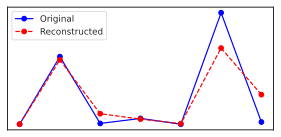

In [205]:
sample_ = train_loader.dataset[4].unsqueeze(0)
reconstruction_fig(model, sample_, scaler)
plt.show()